# RL - Personnal assignment

## Recquirements

In [125]:
%pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [126]:
import os, sys
import gymnasium as gym
import time
from agent import MCQAgent, NStepTreeBackupAgent
import text_flappy_bird_gym
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import random

## Implementing the agents

In [127]:
class MCQ_agent:
    def __init__(self, env, eps):
        self.env = env

        self.eps = eps
        self.eps_decay = 0.99999
        self.eps_min = 0.0001

        self.action_space = env.action_space.n
        self.q_table = {}
        self.state_action_count = {}

        self.episode_states_actions_rewards = []

    def policy(self, state):
        # epsilon-greedy policy
        if np.random.random() < self.eps:
            return self.env.action_space.sample()
        else:
            if state not in self.q_table.keys():
                self.init_state(state)

            return np.argmax(self.q_table[state])
        

    def init_state(self, state):
        self.q_table[state] = np.random.rand(self.env.action_space.n)
        self.state_action_count[state] = np.zeros(self.env.action_space.n)

    def start_episode(self):
        self.episode_states_actions_rewards = []
        self.eps = max(self.eps_decay*self.eps, self.eps_min)

    def update(self, state, action, reward, next_state, done):
        self.episode_states_actions_rewards.append((state, action, reward))

        if done: # AT THE END OF THE EPISODE
            G = 0
            for past_state, past_action, past_reward in self.episode_states_actions_rewards[::-1]:
                if past_state not in self.q_table.keys():
                    self.init_state(past_state)

                G = past_reward + G
                self.state_action_count[past_state][past_action] += 1
                self.q_table[past_state][past_action] += 1 / self.state_action_count[past_state][past_action] * (G - self.q_table[past_state][past_action])


In [128]:
class SARSALambdaAgent:
    def __init__(self, env, lambda_value=0.7, alpha=0.1, gamma=0.99, eps=0.1):
        self.env = env
        self.lambda_value = lambda_value
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = eps

        self.action_space = env.action_space.n
        self.q_table = {}
        self.eligibility_trace = {}

        self.episode_states_actions_rewards = []

    def policy(self, state):
        # epsilon-greedy policy
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            if state not in self.q_table.keys():
                self.init_state(state)

            return np.argmax(self.q_table[state])

    def init_state(self, state):
        self.q_table[state] = np.random.rand(self.env.action_space.n)
        self.eligibility_trace[state] = np.zeros(self.env.action_space.n)

    def start_episode(self):
        self.episode_states_actions_rewards = []

    def update(self, state, action, reward, next_state, done):
        self.episode_states_actions_rewards.append((state, action, reward))
        
        if state not in self.q_table.keys():
            self.init_state(state)
        if next_state not in self.q_table.keys():
            self.init_state(next_state)
        if state not in self.eligibility_trace.keys():
            self.eligibility_trace[state] = np.zeros(self.env.action_space.n)
        if next_state not in self.eligibility_trace.keys():
            self.eligibility_trace[next_state] = np.zeros(self.env.action_space.n)
            

        next_action = self.policy(next_state)
 
        td_target = reward + self.gamma * self.q_table[next_state][next_action] - self.q_table[state][action]
        self.eligibility_trace[state][action] += 1
        for st, act in self.eligibility_trace.items():
            if st not in self.q_table.keys():
                self.init_state(st)

            self.q_table[st] += self.alpha * td_target * act
            self.eligibility_trace[st] *= self.gamma * self.lambda_value

        if done:
            self.eligibility_trace = {}

## Comparing and analysis

In [129]:
def train(agent, env, num_episodes):
    scores = []
    rewards = []

    for episode in trange(num_episodes):

        state = env.reset()
        state = state[0]

        done = False
        episode_score = 0
        total_reward = 0

        agent.start_episode()

        while not done:

            action = agent.policy(state)

            next_state, reward, done, _, info = env.step(action)

            agent.update(state, action, reward, next_state, done)

            state = next_state

            episode_score = info['score']
            total_reward += reward
            if episode_score > 1000:  # if the agent is doing well, break the episode
                print('limit reached')
                break

        rewards.append(total_reward)
        scores.append(episode_score)

    env.close()
    return scores, rewards


Training MCQ_agent with eps = [0.1, 0.3, 0.5]


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:07<00:00, 1259.40it/s]


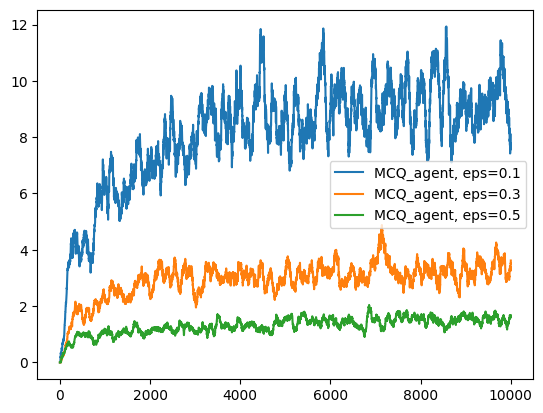


Training SARSALambdaAgent with lambda_value = [0.5, 0.7, 0.9]


100%|██████████| 10000/10000 [04:09<00:00, 40.08it/s]


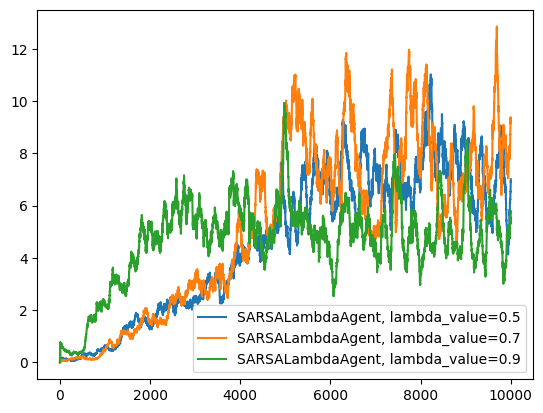

In [130]:
#plot evolution scores

def moving_average(data, window_size=100):
    """Calculate the moving average of a list."""
    moving_avg = []
    for i in range(len(data)):
        window = data[max(0, i - window_size + 1): i + 1]
        avg = sum(window) / len(window) if window else 0
        moving_avg.append(avg)
    return moving_avg


def train_and_compare_agents(env, agents, params, num_episodes):
    for agent_name, agent_class in agents.items():
        for param_name, param_value in params[agent_name].items():
            print(f"\nTraining {agent_name} with {param_name} = {param_value}")
            for param in param_value:
                agent = agent_class(env, **{param_name: param})
                scores, rewards = train(agent, env, num_episodes)
                plt.plot(moving_average(scores), label=f"{agent_name}, {param_name}={param}")
            plt.legend()
            plt.show()

if __name__ == '__main__':
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

    # define agents and parameters to vary
    agents = {
        "MCQ_agent": MCQ_agent,
        "SARSALambdaAgent": SARSALambdaAgent,
    }
    params = {
        "MCQ_agent": {"eps": [0.1, 0.3, 0.5]},
        "SARSALambdaAgent": {"lambda_value": [0.5, 0.7, 0.9]},
    }

    # Learning phase
    num_episodes = 10000
    train_and_compare_agents(env, agents, params, num_episodes)
